<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/02-bow%2Blr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo 50 JAIIO: Regresión logística
__Título:__ Etiquetado semi-supervisado multiclase de correos electrónicos a partir de estrategias de extracción de características y _Elasticsearch_

__Autores:__ Juan Manuel Fernandez, Marcelo Errecalde


En esta notebook se presentan los experimentos sobre _feature extraction_ con LR para las 50 JAIIO.

## Instalación y Carga de librerías y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [9]:
!pip install requests
!pip install wget

### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [10]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [11]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

## Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [12]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'
TRAIN_FILE = 'correos-train-jaiio-80.csv'
TEST_FILE = 'correos-test-jaiio-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['consulta'] = pd.Series(preprocesar_correos(train_df['consulta']))
test_df['consulta'] = pd.Series(preprocesar_correos(test_df['consulta']))

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))


El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Ingreso a la Universidad' 'Requisitos de Ingreso'
 'Pedido de Certificados' 'Situación Académica' 'Exámenes'
 'Boleto Universitario' 'Cursadas' 'Consulta sobre Título Universitario'
 'Consulta por Legajo' 'Consulta por Equivalencias' 'Reincorporación'
 'Problemas con la Clave' 'Simultaneidad de Carreras' 'Datos Personales'
 'Cambio de Carrera' 'Cambio de Comisión'].


## Regresión Logística

Se carga en memoria la función _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __LR__ y _representacion_documentos_ con la generación de las diferentes representaciones:

In [13]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion, representacion_documentos

### Definición del espacio de búsqueda

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [14]:
# Defino una lista con los esquemas de representación
estrategias_representacion = ['BOW', 'TFIDF', '1-2-NGRAM-WORDS', 'BINARIO']
modelo = 'LR'
# Defino los parámetros para GridSearchCV
params_lr = {'LR__C': [0.001, 0.01, 0.1, 1, 10, 100]}

### Ajuste del Modelo

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [ ]:
for estrategia in estrategias_representacion:
  # Llamo a la función que realiza el gridsearch por estrategia  
  gridsearch_por_estrategia_representacion(train_df, test_df, estrategia, modelo, params_lr, False, atr_consulta='consulta')

Estrategia de representación: BOW
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.1s finished


Mounted at drive
Estrategia de representación: BOW
Parámetros: {'LR__C': 100, 'clasificador': 'LR', 'estrategia': 'BOW', 'accuracy': 0.715, 'precision': 0.389478354978355, 'recall': 0.3792313699893487, 'f1_score': 0.3728233145534763}
Accuracy Test-Set: 0.715
Estrategia de representación: TFIDF
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.4s finished


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Estrategia de representación: TFIDF
Parámetros: {'LR__C': 10, 'clasificador': 'LR', 'estrategia': 'TFIDF', 'accuracy': 0.72, 'precision': 0.4068827967100959, 'recall': 0.36212746473384766, 'f1_score': 0.3646011844973317}
Accuracy Test-Set: 0.72
Estrategia de representación: 1-2-NGRAM-WORDS
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Estrategia de representación: 1-2-NGRAM-WORDS
Parámetros: {'LR__C': 100, 'clasificador': 'LR', 'estrategia': '1-2-NGRAM-WORDS', 'accuracy': 0.695, 'precision': 0.27858767576509513, 'recall': 0.26683137193775497, 'f1_score': 0.26165717297351376}
Accuracy Test-Set: 0.695
Estrategia de representación: BINARIO
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.8s finished


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Estrategia de representación: BINARIO
Parámetros: {'LR__C': 1, 'clasificador': 'LR', 'estrategia': 'BINARIO', 'accuracy': 0.725, 'precision': 0.4617301727048962, 'recall': 0.3710590886654716, 'f1_score': 0.3918418084397466}
Accuracy Test-Set: 0.725


### Testeo del modelo

Se construye y testea el modelo en función de los mejores hiperparámetros encontrados:

In [15]:
from funciones_dataset import consolidar_df
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Genero la representación de documentos
correos_train_vec, correos_test_vec = representacion_documentos(train_df['consulta'], test_df['consulta'], 'BINARIO', None)

# Separo en x e y - train y test- (además consolido feature estáticas con dinámicas)
x_train, y_train = consolidar_df(train_df, correos_train_vec, 'consulta', 'clase')
x_test, y_test = consolidar_df(test_df, correos_test_vec, 'consulta', 'clase')

# Escalado de datos: Se probó scale y MinMaxScaler y dió mejores resultados el último
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# Instancio y entreno el modelo
clf = LogisticRegression(C=1)
clf.fit(x_train_scaled, y_train)

# Se realizan las predicciones sobre el conjunto de validación
y_predictions = clf.predict(x_test_scaled) 

# Calculo el accuracy sobre test
acc_test = accuracy_score(y_test, y_predictions)

print('Accuracy Test-Set: {}' . format(acc_test))

Accuracy Test-Set: 0.765


### Vector de coeficientes

Ahora se retornan los vectores de coeficientes para las clases:

In [16]:
clf.coef_

array([[-0.30246746, -0.45018598, -0.03847186, ..., -0.00186904,
         0.11977351, -0.0562871 ],
       [ 0.15876268, -0.12961847, -0.01496878, ..., -0.00126335,
        -0.00140099, -0.00467303],
       [ 0.56073884,  0.32400464, -0.324657  , ..., -0.00159296,
        -0.00660797, -0.01047734],
       ...,
       [-0.39965686,  0.36777052, -0.14518773, ..., -0.01836234,
        -0.02344014, -0.03083209],
       [-0.15256079,  0.21476019, -0.07209822, ..., -0.00070395,
        -0.00088031, -0.0037259 ],
       [ 0.09344944, -0.1144564 ,  0.36928925, ..., -0.00089772,
        -0.0143376 , -0.02017321]])

Se instala la librería _mglearn_ para el ploteo de los términos importantes en función de los coeficientes:

In [17]:
!pip install mglearn

     |████████████████████████████████| 542kB 28.8MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=8db07a132ffb144f8ce5c77ef5beb4eba05bb81e5a65d064ffa4dfbc4629fdfb
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


Se construyen los plots por cada clase:



		Gráfico de ponderación de coeficientes de la LR para la clase Cambio de Carrera


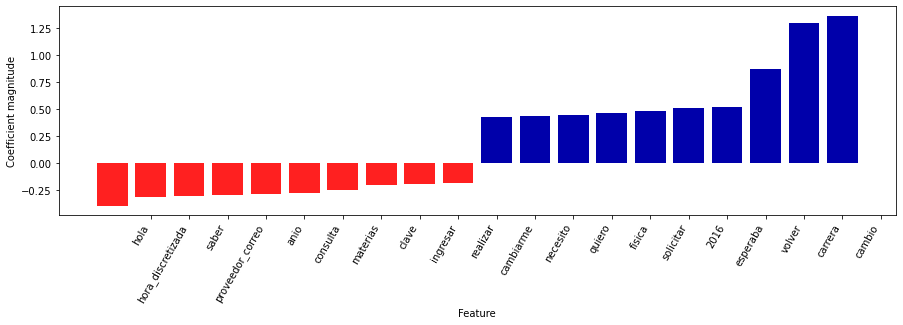



		Gráfico de ponderación de coeficientes de la LR para la clase Cambio de Comisión


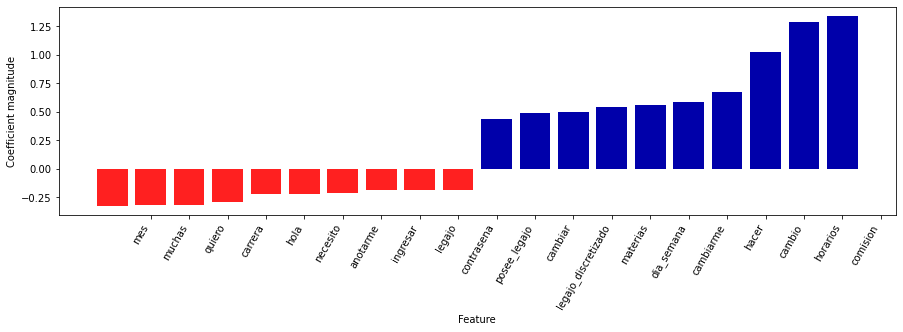



		Gráfico de ponderación de coeficientes de la LR para la clase Consulta por Equivalencias


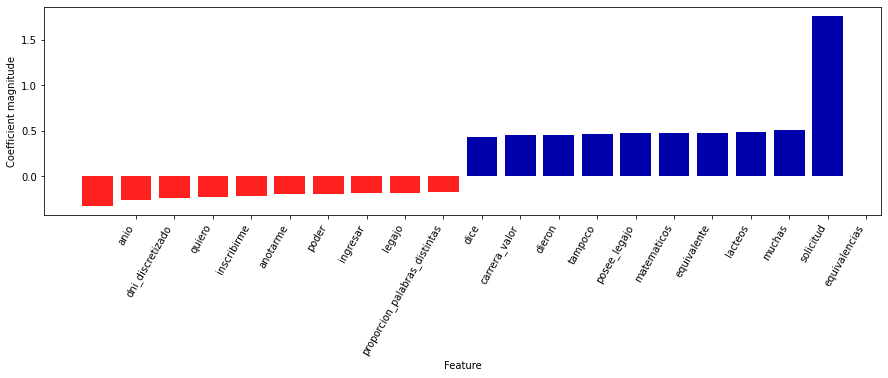



		Gráfico de ponderación de coeficientes de la LR para la clase Consulta por Legajo


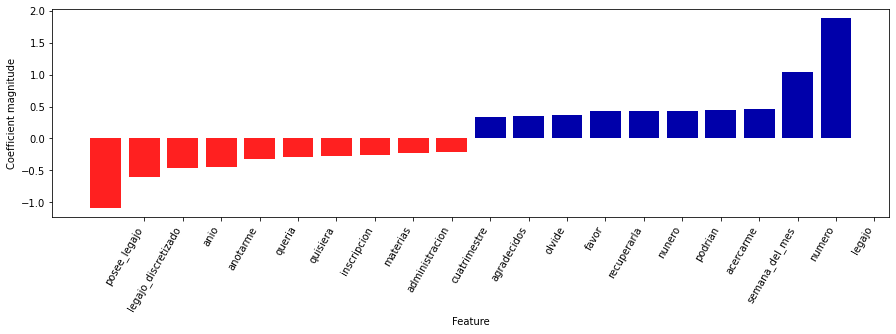



		Gráfico de ponderación de coeficientes de la LR para la clase Consulta sobre Título Universitario


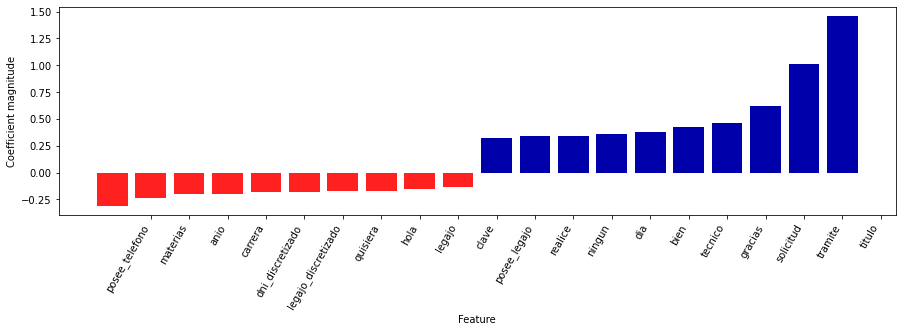



		Gráfico de ponderación de coeficientes de la LR para la clase Cursadas


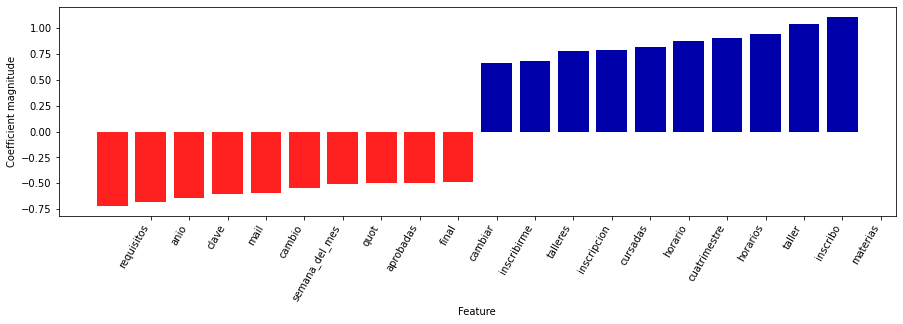



		Gráfico de ponderación de coeficientes de la LR para la clase Datos Personales


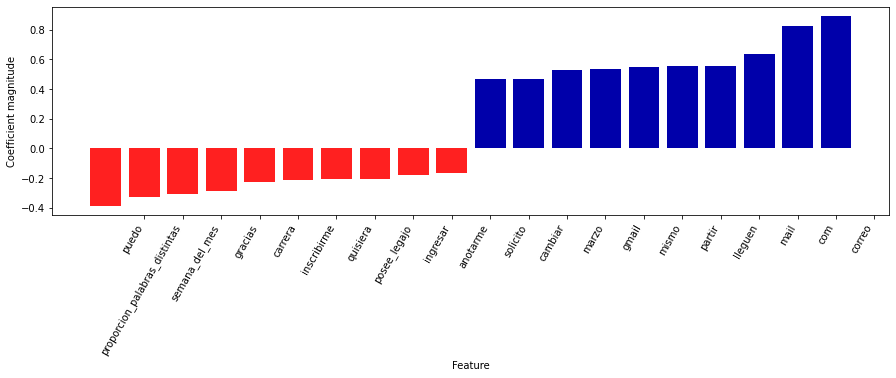



		Gráfico de ponderación de coeficientes de la LR para la clase Exámenes


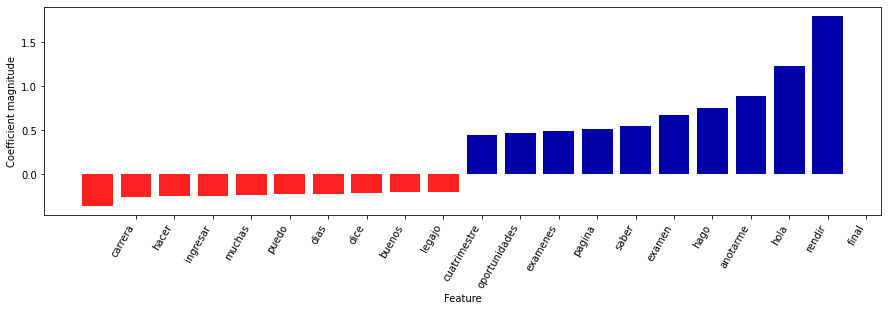



		Gráfico de ponderación de coeficientes de la LR para la clase Ingreso a la Universidad


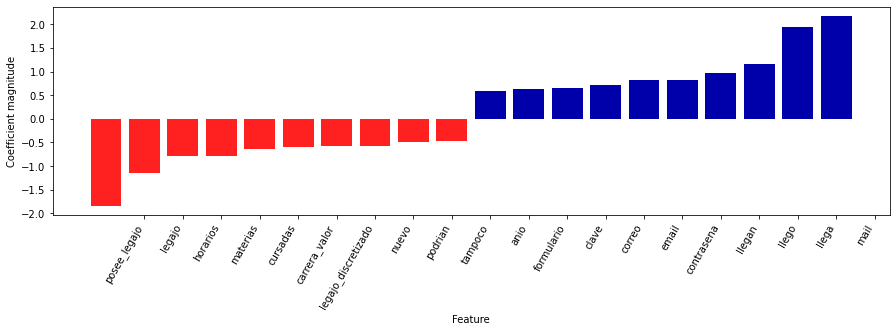



		Gráfico de ponderación de coeficientes de la LR para la clase Pedido de Certificados


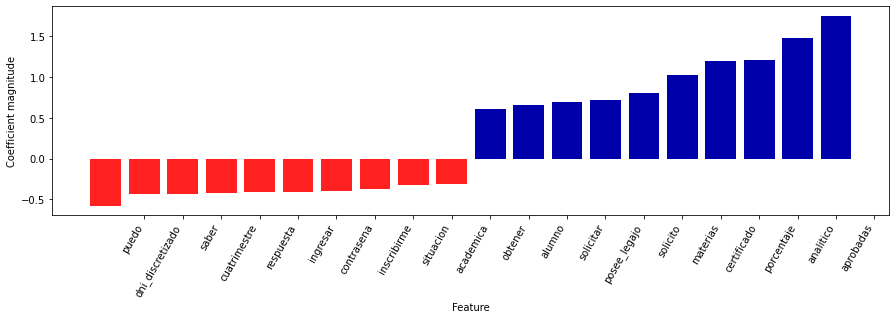



		Gráfico de ponderación de coeficientes de la LR para la clase Problemas con la Clave


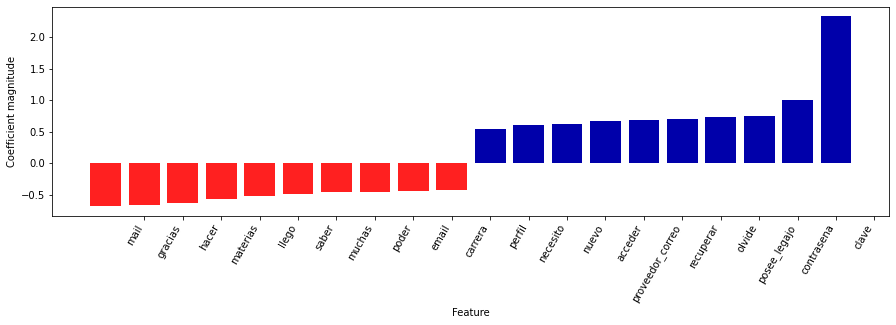



		Gráfico de ponderación de coeficientes de la LR para la clase Reincorporación


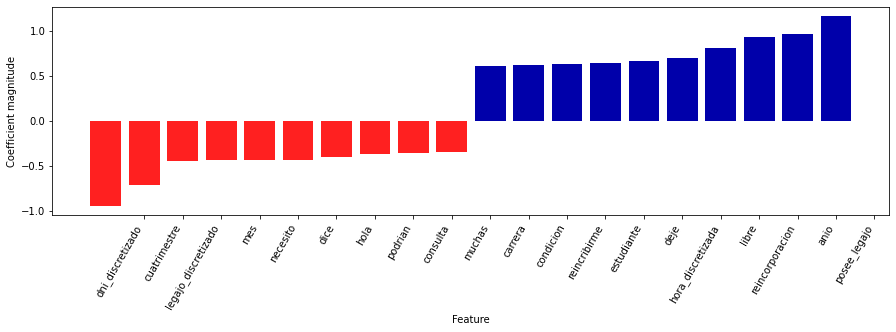



		Gráfico de ponderación de coeficientes de la LR para la clase Requisitos de Ingreso


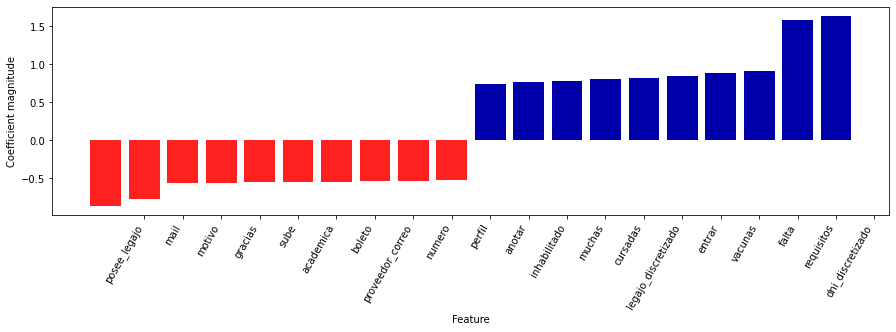



		Gráfico de ponderación de coeficientes de la LR para la clase Simultaneidad de Carreras


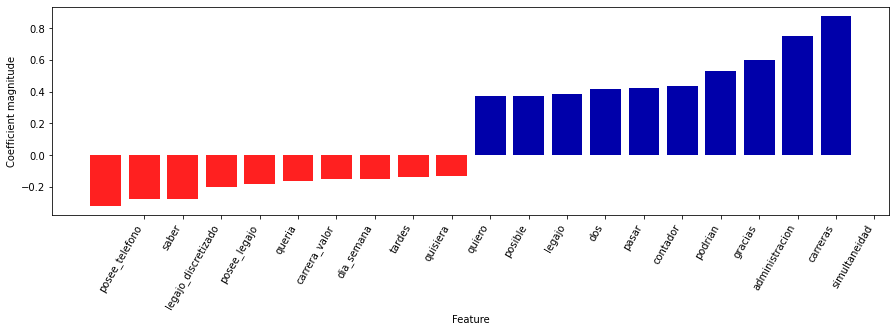

In [18]:
from mglearn.tools import visualize_coefficients
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(1, len(etiquetas)-1):
  print(f'\n\n\t\tGráfico de ponderación de coeficientes de la LR para la clase {etiquetas[i]}')
  visualize_coefficients(clf.coef_[i], x_train.columns, n_top_features=10)
  # Muestro el gráfico
  plt.show()

## Términos representativos por clase

Ahora se genera un dataframe con los coeficientes por feature por clase:
- Filas: clase
- Columnas: términos

In [19]:
import pandas as pd
import numpy as np

features = x_train.columns.values
#features = np.insert(features, 0, 'clase', axis=0)

df = pd.DataFrame(clf.coef_, columns=x_train.columns.values)
df['clase'] = pd.Series(etiquetas)
df.set_index('clase', inplace = True)

Ahora transpongo el dataframe:

In [20]:
df_t = df.transpose()

df_t

clase,Boleto Universitario,Cambio de Carrera,Cambio de Comisión,Consulta por Equivalencias,Consulta por Legajo,Consulta sobre Título Universitario,Cursadas,Datos Personales,Exámenes,Ingreso a la Universidad,Pedido de Certificados,Problemas con la Clave,Reincorporación,Requisitos de Ingreso,Simultaneidad de Carreras,Situación Académica
dia_semana,-0.302467,0.158763,0.560739,0.126876,-0.114560,-0.094518,-0.014111,0.355393,-0.083040,-0.253494,-0.127178,0.061428,0.184937,-0.399657,-0.152561,0.093449
semana_del_mes,-0.450186,-0.129618,0.324005,-0.127076,0.458614,0.256681,-0.543959,-0.307874,-0.001334,0.077705,0.202523,0.089501,-0.317056,0.367771,0.214760,-0.114456
mes,-0.038472,-0.014969,-0.324657,-0.107499,-0.101877,0.259675,-0.051886,-0.111721,0.223769,0.295246,0.312658,-0.050721,-0.441551,-0.145188,-0.072098,0.369289
cuatrimestre,-0.274354,-0.080400,-0.092418,0.064364,-0.218396,0.243173,-0.124875,0.072966,0.035346,0.528103,0.368667,-0.039938,-0.715911,0.019925,-0.106837,0.320585
anio,1.120251,-0.283673,0.045694,-0.324979,-0.467009,-0.203420,-0.684198,-0.017687,-0.096624,0.590871,-0.037041,-0.407740,0.962001,0.289521,-0.083129,-0.402838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vuelvo,0.001044,-0.000033,-0.000022,-0.000044,-0.000012,-0.000068,-0.000054,-0.000036,-0.000052,-0.000169,-0.000039,-0.000067,-0.000040,-0.000183,-0.000035,-0.000191
web,-0.121782,-0.070745,-0.059165,-0.069560,-0.116841,0.046333,0.043306,-0.056904,-0.114376,0.260694,-0.034943,-0.042636,0.539267,-0.378834,-0.029088,0.205273
wep,-0.001869,-0.001263,-0.001593,-0.000988,-0.003935,-0.000566,-0.006949,-0.005205,-0.001128,0.053613,-0.001011,-0.006665,-0.002478,-0.018362,-0.000704,-0.000898
xq,0.119774,-0.001401,-0.006608,-0.003822,-0.001493,-0.001350,-0.014786,-0.005187,-0.014331,0.003754,-0.007488,-0.006269,-0.022134,-0.023440,-0.000880,-0.014338


## Extracción de Features

Por último, se guardan los terminos que más impacto tienen para la clase positiva y negativa por cada clase.

En primer lugar, se crea la carpeta donde se persisten dos txt por clase, uno con los términos positivos (y su ponderación) y otro con los términos negativos:

In [21]:
!mkdir txts_lr

Genero los txt con los términos más (y menos) importantes por clase:

In [22]:
# Se define la cantidad de términos (positivos y negativos) a persistir por clase
N=10

# Recorro las clases una a una para obtener los términos más importantes
for clase in df_t.columns:
  
  # Tomo la columna del df que le corresponde a la clase
  clase_series = df_t[clase]

  # Genero un df con los términos y el valor
  terminos_clase = clase_series.to_frame()
  terminos_clase.reset_index(inplace=True)
  terminos_clase.columns = ['termino', 'valor']

  # Ordeno de forma descendente para quedarme con los más importantes
  ####################################################################
  terminos_clase.sort_values(by='valor', ascending=False, inplace=True)
  terminos_clase_pos = terminos_clase.head(N)
  # Guardo los términos importantes para la clase con su ponderación en un txt
  print(f'Se genera el txt con valores positivos de la clase {clase}.')
  txt_name = "txts_lr/" + clase + "-pos.txt"
  terminos_clase_pos.to_csv(txt_name, sep=',', index=False)

  # Ordeno de forma ascendente para quedarme con los más importantes
  ####################################################################
  terminos_clase.sort_values(by='valor', ascending=True, inplace=True)
  terminos_clase_neg = terminos_clase.head(N)
  # Guardo los términos menos importantes para la clase con su ponderación en un txt
  print(f'Se genera el txt con valores negativos de la clase {clase}.')
  txt_name = "txts_lr/" + clase + "-neg.txt"
  terminos_clase_neg.to_csv(txt_name, sep=',', index=False)


Se genera el txt con valores positivos de la clase Boleto Universitario.
Se genera el txt con valores negativos de la clase Boleto Universitario.
Se genera el txt con valores positivos de la clase Cambio de Carrera.
Se genera el txt con valores negativos de la clase Cambio de Carrera.
Se genera el txt con valores positivos de la clase Cambio de Comisión.
Se genera el txt con valores negativos de la clase Cambio de Comisión.
Se genera el txt con valores positivos de la clase Consulta por Equivalencias.
Se genera el txt con valores negativos de la clase Consulta por Equivalencias.
Se genera el txt con valores positivos de la clase Consulta por Legajo.
Se genera el txt con valores negativos de la clase Consulta por Legajo.
Se genera el txt con valores positivos de la clase Consulta sobre Título Universitario.
Se genera el txt con valores negativos de la clase Consulta sobre Título Universitario.
Se genera el txt con valores positivos de la clase Cursadas.
Se genera el txt con valores nega

In [23]:
!ls txts_lr/

'Boleto Universitario-neg.txt'
'Boleto Universitario-pos.txt'
'Cambio de Carrera-neg.txt'
'Cambio de Carrera-pos.txt'
'Cambio de Comisión-neg.txt'
'Cambio de Comisión-pos.txt'
'Consulta por Equivalencias-neg.txt'
'Consulta por Equivalencias-pos.txt'
'Consulta por Legajo-neg.txt'
'Consulta por Legajo-pos.txt'
'Consulta sobre Título Universitario-neg.txt'
'Consulta sobre Título Universitario-pos.txt'
 Cursadas-neg.txt
 Cursadas-pos.txt
'Datos Personales-neg.txt'
'Datos Personales-pos.txt'
 Exámenes-neg.txt
 Exámenes-pos.txt
'Ingreso a la Universidad-neg.txt'
'Ingreso a la Universidad-pos.txt'
'Pedido de Certificados-neg.txt'
'Pedido de Certificados-pos.txt'
'Problemas con la Clave-neg.txt'
'Problemas con la Clave-pos.txt'
 Reincorporación-neg.txt
 Reincorporación-pos.txt
'Requisitos de Ingreso-neg.txt'
'Requisitos de Ingreso-pos.txt'
'Simultaneidad de Carreras-neg.txt'
'Simultaneidad de Carreras-pos.txt'
'Situación Académica-neg.txt'
'Situación Académica-pos.txt'


Se zipea y se guarda en Google Drive:

In [24]:
import shutil
shutil.make_archive('txts_lr', 'zip', 'txts_lr')

ENTORNO='Colab'
if ENTORNO=='Colab':
  from google.colab import drive
  drive.mount('drive')
  !cp txts_lr.zip "drive/My Drive/"

Mounted at drive


# Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05